 # A Deep Learning Approach to Predicting Cryptocurrency Prices (Ethereum, Bitcoin, etc.)
 
##### We will Implement a recurrent neural network to predict bitcoin prices

![alt text](https://dashee87.github.io/images/bitcoin_ether_training_test.png "Logo Title Text 1")
 

In [1]:
## Keras for deep learning
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#for logging
import time

##matrix math
import numpy as np
import math

##plotting
import matplotlib.pyplot as plt

##data processing
import pandas as pd

![alt text](http://2.bp.blogspot.com/-wuinSTn-X4A/UwHmmceDQqI/AAAAAAAAJFo/5EjPg-LpAJc/s1600/Sivakumar_Vellingiri_Normal_Forms_Poster.Jpeg "Logo Title Text 1")

# Step 1 - Data Processing

- The data is inputed as a .csv file.
- Lets time-series transform data from (num days x num features) to (num days- window size x num days per sample x num features) where window size is 50
- Normalization via dividing each value in the window by the first value of the window and then subtracting one.i.e [4,3,2] into [0, -0.25, -0.5]. .
- The unnormalized bases are kept to compare the model's predictions of prices with the true prices. 
- The first 90% of the data is used in training the model, and the last 10% will be used to test the model. 
- A list of the prices before each day Y_test is drawn from will be compiled in order to generate statistics about the model's predictions

======================================================================================================================

The columns of data and their definitions are as follows: 
- Annual Hash Growth: Growth in the total network computations over the past 365 days
- Block Height: The total number of blocks in the blockchain
- Block Interval: Average amount of time between blocks
- Block Size: The storage size of each block (i.e. megabytes)
- BlockChain Size: The storage size of the blockchain (i.e. gigabytes)
- Daily Blocks: Number of blocks found each day
- Chain Value Density: The value of bitcoin's blockchain, in terms of dollars per megabyte
- Daily Transactions: The number of transactions included in the blockchain per day
- Difficulty: The minimum proof-of-work threshold required for a bitcoin miner to mine a block
- Fee Percentage: Average fee paid as a percentage of transaction volume
- Fee Rate: Average fee paid per transaction
- Two-Week Hash Growth: Growth in the total network computations over the past 14 days
- Hash Rate: The number of block solutions computed per second by all miners
- Market Capitalization: The market value of all bitcoin in circulation
- Metcalfe's Law - TX: A variant of Metcalfe's Law in which price is divided by n log n number of daily transactions
- Metcalfe's Law - UTXO: A variant of Metcalfe's Law in which price is divided by n log n number of unspent transaction outputs
- Miner Revenue Value: The amount of dollars earned by the mining network
- Miner Revenue: The amount of bitcoin earned by the mining network, in the form of block rewards and transaction fees
- Money Supply: The amount of bitcoin in circulation
- Output Value: The dollar value of all outputs sent over the network
- Output Volume: The amount of Bitcoin sent over the network
- Bitcoin Price: The amount of dollars a single bitcoin is worth
- Quarterly Hash Growth: Growth in the total network computations in the past 90 days
- Total Transactions: The running total number of transactions processed by the Bitcoin network
- Transaction Amount: The average amount of bitcoin moved per transaction
- Fees Value: The dollar value of mining fees
- Transaction Fees: The amount of bitcoin paid to miners in fees
- Transaction Size: The average data size of a transaction
- Transaction Value: The average dollar value moved in each transaction
- Transactions per Block: The number of transactions in each block
- Average UTXO Amount: The average amount of bitcoin contained in each unspent transaction output
- UTXO Growth: The net number of unspent transaction outputs created
- UTXO Set Size: The total number of unspent transaction outputs
- Average UTXO Value: The average dollar value of each uspent transaction output
- Velocity - Daily: The proportion of the money supply transacted each day
- Velocity - Quarterly: The proportion of the money supply transacted each day, computed on a rolling-quarter basis
- Velocity of Money: How many times the money supply changes hands in a given year

In [2]:
x = np.array([[[1,2,3], [4,5,6]],[[1,2,3], [4,5,6]]])

In [3]:
x[:,1].shape

(2, 3)

In [4]:
x.shape

(2, 2, 3)

In [5]:
def load_data(filename, sequence_length):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    X_train -- A tensor of shape (2400, 49, 35) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2400,) that will be inputed into the model to train it
    X_test -- A tensor of shape (267, 49, 35) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (267,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (267,) that represents the price of bitcoin the day before each Y_test value
    unnormalized_bases -- A tensor of shape (267,) that will be used to get the true prices from the normalized ones
    window_size -- An integer that represents how many days of X values the model can look at at once
    """
    #Read the data file
    raw_data = pd.read_csv(filename, dtype = float).values
    
    #Change all zeros to the number before the zero occurs
    for x in range(0, raw_data.shape[0]):
        for y in range(0, raw_data.shape[1]):
            if(raw_data[x][y] == 0):
                raw_data[x][y] = raw_data[x-1][y]
    
    #Convert the file to a list
    data = raw_data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Keeping the unnormalized prices for Y_test
    #Useful when graphing bitcoin price over time later
    start = 2400
    end = int(dr.shape[0] + 1)
    unnormalized_bases = d0[start:end,0:1,20]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
    Y_train = Y_train[:, 20]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
    Y_test = Y_test[:, 20]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
    Y_daybefore = Y_daybefore[:, 20]
    
    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

# Step 2 - Building the Model

- We'll use a 3layer RNN with  20% dropout at each layer to reduce overfitting to the training data. 
- This model will have 515,579 trainable parameters throughout all of its layers. 
- The model uses the AdamOptimizer as its optimization function.
- The loss function used in this model is mean squared error. 
- A linear activation function is used in this model to determine the output of each neuron in the model. The linear activation function is simply defined as f(x) = x.
- The model will use Keras's Sequential model with Bidirectional LSTM layers.

![alt text](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg "Logo Title Text 1")
![alt text](https://docs.microsoft.com/en-us/azure/machine-learning/preview/media/scenario-tdsp-biomedical-recognition/lstm-cell.png "Logo Title Text 1")
![alt text](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/bidirectional-rnn.png "Logo Title Text 1")
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png "Logo Title Text 1")


Bidirectional RNNs are based on the idea that the output at time t may not only depend on the previous elements in the sequence, but also future elements. For example, to predict a missing word in a sequence you want to look at both the left and the right context. Bidirectional RNNs are quite simple. They are just two RNNs stacked on top of each other. The output is then computed based on the hidden state of both RNNs.

In [6]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    """
    Initializes and creates the model to be used
    
    Arguments:
    window_size -- An integer that represents how many days of X_values the model can look at at once
    dropout_value -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((window_size*2), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

# Step 3 - Training the Model

- The model will be fitted to the training dat with a batch_size of 1024. 
- Additionally, 100 epochs will be performed to give the model time to adjust its weights and biases to fit the training data.
- 5% of the training data will be used as the validation set.  
- The model will train by minimizing the loss (mean squared error) of its training data. -- - The validation set is useful when attempting to identify signs of overfitting. 
- If the validation loss begins to consistently and rapidly increase, the model has overfitted to the training data, and changes should be made to the model. 


In [7]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2400, 49, 35) that represents the x values of the training data
    Y_train -- A tensor of shape (2400,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 1024
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

# Step 4 - Testing the Model

- The models given x values of testing data & will predict normalized prices (y_predict)
- Then, both the predicted values and the real values will be unnormalized and stored in separate arrays. 
- The values are unnormalized by looping through the predicted and true values. 
- 1 is added to each value, and then the result is multiplied by a corresponding number in the unnormalized_bases array. 
- In other words, the unnormalization processs is the exact reverse of the normalization process
- Finally, a plot is created of the unnormalized real values and the unnormalized predicted values. 

In [8]:
def test_model(model, X_test, Y_test, unnormalized_bases):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (267, 49, 35) that represents the x values of the testing data
    Y_test -- A tensor of shape (267,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (267,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (267,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (267,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (267,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    y_predict = model.predict(X_test)

    #Create empty 2D arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

# Step 5 - Evaluating Change in Price

- Lets plot the model's predicted change in price each day against the real change in price daily
- The percent increases of the predicted values and the real values are calculated by subtracting the value from the day before from the predicted/real value then dividing the result by 1+the value from the day before. 
- The predicted change in price is stored in delta_predict, while the real change in price is stored in delta_real.
- These two tensors are then graphed together to visualize the difference between predicted and real change in price for bitcoin throughout the testing period. 
- The plot will represent the percent change in bitcoin price each day. 

In [9]:
def price_change(Y_daybefore, Y_test, y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    Y_daybefore -- A tensor of shape (267,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267,) that represents the normalized y values of the model's predictions
    
    Returns:
    Y_daybefore -- A tensor of shape (267, 1) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    delta_predict -- A tensor of shape (267, 1) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (267, 1) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day befhen subtracting one.i.e [4,3,2] inore
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

# Step 6 - Process the Percent Change in Price

- The percent change in price will be processsed such that an increase in price is represented by a 1, and a decrease/no change is represented by a 0. These binary values will be stored in arrays delta_predict_1_0 and delta_real_1_0. 

- This will be done by looping through the values of the real and predicted percent change arrays. If a value is greater than 0, a 1 is stored in a new array. Otherwise, a 0 is stored in the new array.

- This process is very useful to understand how well the model did, and can be used to gather statistics about the model's performance.

In [10]:
def binary_price(delta_predict, delta_real):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (267, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (267, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0    

    return delta_predict_1_0, delta_real_1_0

# 7 - Comparing Predictions and Real Data

The binary categories computed in the previous cell is now used to compare predicted and real data. It will be used to find the number of:
- True positives
- False positives
- True negatives
- False negatives
These can then be used to further calculate statistics of the model's performance. 

This will be done by looping through both binary arrays at once and getting the corresponding values. If the real value is a 1 and the predicted value is a 1, that index will be counted as a true positive. If the real value is a 1 and the predicted value is a 0, that index will be counted as a false negative. If the real value is a 0 and the predicted value is a 0, that index will be counted as a true negative. If the real value is a 0 and the predicted value is a 1, that index will be counted as a false positive.

In [11]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

# 8 - Calculating Statistics

![alt text](https://www.researchgate.net/profile/Alexandros_Karatzoglou/publication/221515860/figure/fig1/AS:339586132791298@1457975051470/Figure-1-Mean-Squared-Error-formula-used-to-evaluate-the-user-model.ppm "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/qconrio-machinelearningforeveryone-150826200704-lva1-app6892/95/qcon-rio-machine-learning-for-everyone-51-638.jpg?cb=1440698161 "Logo Title Text 1")


Putting everything together and getting statistics about the model. Statistics being calculated include:
- Precision: How often the model gets a true positive compared to how often it returns a positive
- Recall: How often the model gets a true positive compared to how often it should have gotten a positive
- F1 Score: The weighted average of recall and precision
- Mean Squared Error: The average of the squares of the differences between predicted and real values

In [12]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    """
    Calculate various statistics to assess performance
    
    Arguments:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267, 1) that represents the normalized y values of the model's predictions
    
    Returns:
    precision -- How often the model gets a true positive compared to how often it returns a positive
    recall -- How often the model gets a true positive compared to how often is hould have gotten a positive
    F1 -- The weighted average of recall and precision
    Mean Squared Error -- The average of the squares of the differences between predicted and real values
    """
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

# 9 - Putting It All Together

Applying all the methods defined above and analyzing results.

## Loading the Data

In [13]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data("random_data.csv", 50)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (Y_daybefore.shape)
print (unnormalized_bases.shape)
print (window_size)

(4455, 49, 35)
(4455,)
(495, 49, 35)
(495,)
(495,)
(2550, 1)
49


In [55]:
pd.DataFrame(np.random.rand(5000, 34)).to_csv('random_data.csv')

## Initializing the Model

In [14]:
model = initialize_model(window_size, 0.2, 'linear', 'mse', 'adam')
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 49, 98)            33320     
_________________________________________________________________
dropout (Dropout)            (None, 49, 98)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense (Dense)                (None, 1)                 99        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

## Training the Model

In [15]:
model, training_time = fit_model(model, X_train, Y_train, 1024, 10, .05)

#Print the training time
print ("Training time", training_time, "seconds")

W0404 15:35:03.776890 139804576466752 training.py:692] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4232 samples, validate on 223 samples
Epoch 1/10
4232/4232 [==============================] - 6s 2ms/sample - loss: 20219.9751 - val_loss: 1519.3683
Epoch 2/10
4232/4232 [==============================] - 4s 929us/sample - loss: 20189.7532 - val_loss: 1490.2953
Epoch 3/10
4232/4232 [==============================] - 4s 866us/sample - loss: 20175.5657 - val_loss: 1467.0077
Epoch 4/10
4232/4232 [==============================] - 4s 877us/sample - loss: 20153.9396 - val_loss: 1449.9553
Epoch 5/10
4232/4232 [==============================] - 4s 857us/sample - loss: 20139.6332 - val_loss: 1433.4657
Epoch 6/10
4232/4232 [==============================] - 3s 818us/sample - loss: 20130.3366 - val_loss: 1417.0037
Epoch 7/10
4232/4232 [==============================] - 4s 847us/sample - loss: 20116.7070 - val_loss: 1403.8542
Epoch 8/10
4232/4232 [==============================] - 4s 923us/sample - loss: 20105.5813 - val_loss: 1394.8638
Epoch 9/10
4232/4232 [=============================

In [16]:
model.save('model_random.h5')

## Testing the Model

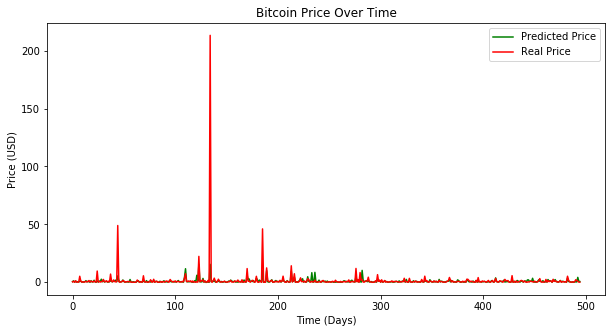

In [58]:
y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

In [50]:
unnormalized_bases

array([], shape=(0, 1), dtype=float64)

## Plotting Percent Change

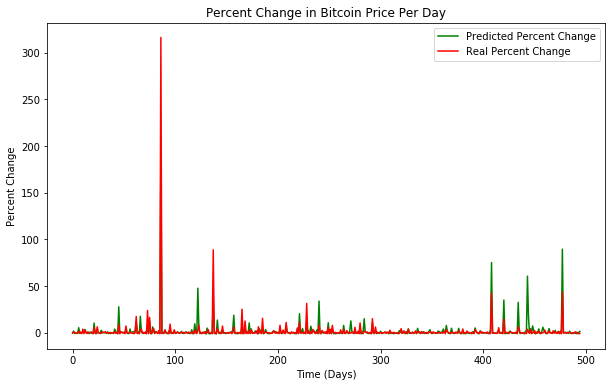

In [59]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

## Getting Binary Version of Percent Change

In [63]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict, delta_real)

print (delta_predict_1_0.shape)
print (delta_real_1_0.shape)

(495, 1)
(495, 1)


## Comparing Predictions and True Data

In [64]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 159
False positives: 77
True negatives: 161
False negatives: 98


## Getting the Statistics

In [42]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print "Precision:", precision
print "Recall:", recall
print "F1 score:", F1
print "Mean Squared Error:", MSE

Precision: 0.62
Recall: 0.553571428571
F1 score: 0.584905660377
Mean Squared Error: 0.0430756924477
0.584905660377
